<a href="https://colab.research.google.com/github/asim5800/Deep-learning-practicals/blob/main/Hybrid_Deep_learning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mega Case Study - Making a hybrid Deep Learning Model

***The challenge is to use the results of this self-organizing map to then combine your unsupervised deep learning model to a new supervised deep learning model that will take, as input, the results given by your self-organizing map.***

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Part 1 - SOM

##Install MiniSom Package

In [68]:
!pip install MiniSom

## Importing the libraries


In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importing the dataset

In [70]:
dataset = pd.read_csv('/content/drive/MyDrive/UNSUPERVISED DEEP LEARNING/Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values 
y = dataset.iloc[:, -1].values

In [71]:
dataset.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


## Feature Scaling


In [72]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

##Training the SOM


In [73]:
from minisom import MiniSom
som = MiniSom(x=10, y=10, input_len= 15, sigma= 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

##Visualizing the results


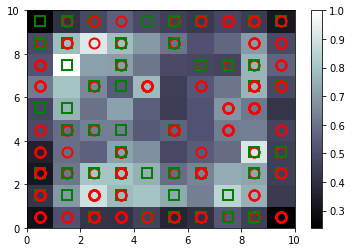

In [74]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

## Finding the frauds


In [76]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(1,7)], mappings[(2,9)], mappings[(9,3)]), axis = 0)
frauds = sc.inverse_transform(frauds)

##Printing the Fraunch Clients

In [77]:
print('Fraud Customer IDs')
for i in frauds[:, 0]:
  print(int(i))

Fraud Customer IDs
15682686
15598614
15572361
15706268
15653147
15802106
15687765
15571081
15625501
15598574


#Part 2 - Going from Unsupervised to Supervised Deep Learning

##Create Matrix of Features

In [78]:
customers = dataset.iloc[:, 1:].values #replacing X earlier as customers include all columns except CUST ID

In [79]:
customers.shape

(690, 15)

## Create Dependent Variable


It will be a fraud with a binary outcome,which will therefore get the value of zero and one,zero if there is no fraud and one if there is fraud.

And so how can we use the results that we obtainedthanks to our unsupervised deep learning model the self organizing map, well we can extract the customer IDs of this list of frauds because basically this list of frauds contains all the customer IDs of the customers that potentially cheated.

So we will use this to create our dependent variable

In [80]:
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
  if dataset.iloc[i,0] in frauds:
    is_fraud[i] = 1

In [81]:
is_fraud.shape

(690,)

#Part 3 - ANN

### Feature Scaling

In [82]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

## Building the ANN


##Import Tensorflow

In [83]:
import tensorflow as tf
tf.__version__

'2.6.0'

## Initializing the ANN

In [84]:
ann = tf.keras.models.Sequential()

##Adding the input layer and the first hidden layer

In [85]:
ann.add(tf.keras.layers.Dense(units=2, activation='relu')) # input_dim=15 can be added

## Adding the output layer

In [86]:
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Training the ANN

## Compiling the ANN

In [87]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## Training the ANN on the Training set

In [88]:
ann.fit(customers, is_fraud, batch_size = 1, epochs = 10)

Epoch 1/10
690/690 [==============================] - 1s 1ms/step - loss: 0.8824 - accuracy: 0.4841
Epoch 2/10
690/690 [==============================] - 1s 1ms/step - loss: 0.4479 - accuracy: 0.9333
Epoch 3/10
690/690 [==============================] - 1s 1ms/step - loss: 0.2886 - accuracy: 0.9797
Epoch 4/10
690/690 [==============================] - 1s 1ms/step - loss: 0.2089 - accuracy: 0.9826
Epoch 5/10
690/690 [==============================] - 1s 1ms/step - loss: 0.1623 - accuracy: 0.9855
Epoch 6/10
690/690 [==============================] - 1s 1ms/step - loss: 0.1331 - accuracy: 0.9855
Epoch 7/10
690/690 [==============================] - 1s 1ms/step - loss: 0.1141 - accuracy: 0.9855
Epoch 8/10
690/690 [==============================] - 1s 1ms/step - loss: 0.1017 - accuracy: 0.9855
Epoch 9/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0932 - accuracy: 0.9855
Epoch 10/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0869 - accuracy: 0.9855

## Predicting test set results

In [89]:
y_pred = ann.predict(customers)#probabilty of each customer cheated
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1) #cusotmer id , with respective probabilities 
y_pred = y_pred[y_pred[:, 1].argsort()] 

In [90]:
print(y_pred)

[[1.57761560e+07 3.95665467e-02]
 [1.56405210e+07 3.95665467e-02]
 [1.57906300e+07 3.95665467e-02]
 ...
 [1.56531470e+07 6.65089190e-02]
 [1.58021060e+07 6.71010613e-02]
 [1.56058720e+07 7.29288757e-02]]


In [91]:
prob=pd.DataFrame(y_pred, columns=['Customer ID', 'Probability of fraud']) 


In [92]:
prob 

,Customer ID,Probability of fraud
0,15776156.0,0.039567
1,15640521.0,0.039567
2,15790630.0,0.039567
3,15664720.0,0.039567
4,15750055.0,0.039567
...,...,...
685,15569595.0,0.062759
686,15790113.0,0.063452
687,15653147.0,0.066509
688,15802106.0,0.067101


***We can give above ranking to the fraud department to have more better solution to this business problem.***